# Analyze participants

By Ben Welsh

Analyzes the activity of participants in the California Civic Data Coalition's open-source projects.

In [277]:
import os
import math
import time
import folium
import pandas as pd
import numpy as np
from selenium import webdriver
import matplotlib.pyplot as plt
from IPython.core.display import Image

In [278]:
pd.options.display.max_rows = 5000
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [279]:
%matplotlib inline

In [280]:
this_dir = os.getcwd()
output_dir = os.path.join(this_dir, 'output')

In [281]:
unique_contributors = pd.read_csv(os.path.join(output_dir, "participants.csv"))

## GitHub totals 

In [282]:
total_contributors = len(unique_contributors)
total_contributors

144

In [283]:
total_contributions = unique_contributors.contributions.sum()
total_contributions

5416

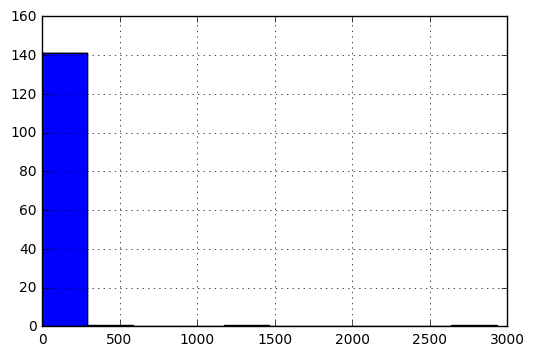

In [263]:
unique_contributors.contributions.hist()

## GitHub rankings

In [223]:
def rank_by_contributors(table, field):
    grouped = table.groupby(field, as_index=False)
    summed = grouped.login.count()
    summed.columns = [field, 'count']
    return summed

In [224]:
def rank_by_contributions(table, field):
    grouped = table.groupby(field, as_index=False)
    return grouped.contributions.sum()

In [225]:
def create_ranking(table, field):
    count = rank_by_contributors(table, field)
    summed = rank_by_contributions(table, field)
    merged = count.merge(summed)
    merged['count_percent'] = merged['count'] / total_contributors
    merged['contributions_percent'] = merged['contributions'] / total_contributions
    return merged.sort_values("contributions", ascending=False)

In [226]:
create_ranking(unique_contributors, 'name')[['name', 'contributions', 'contributions_percent']].head(20)

,name,contributions,contributions_percent
18,Ben Welsh,2932,0.54
58,James Gordon,1329,0.25
0,Aaron Williams,379,0.07
115,Sahil Chinoy,126,0.02
1,Agustin Armendariz,69,0.01
20,Bill Chambers,47,0.01
13,Anthony Pesce,40,0.01
24,Casey Miller,33,0.01
70,Juan Elosua,29,0.01
86,Luciana Godoy,25,0.00


In [227]:
create_ranking(unique_contributors, 'company').head(20)

,company,count,contributions,count_percent,contributions_percent
42,Los Angeles Times,16,3016,0.11,0.56
14,California Civic Data Coalition,1,1329,0.01,0.25
78,Washington Post,3,387,0.02,0.07
69,UC Berkeley,1,126,0.01,0.02
49,New York Times,4,73,0.03,0.01
44,Mozilla OpenNews,7,47,0.05,0.01
22,Databricks,1,47,0.01,0.01
76,Vox Media,2,36,0.01,0.01
46,NPR,1,29,0.01,0.01
70,UC San Diego,1,20,0.01,0.00


In [228]:
create_ranking(unique_contributors, 'location').head(20)

,location,count,contributions,count_percent,contributions_percent
25,"Los Angeles, CA",19,3023,0.13,0.56
11,"Columbia, MO",3,1331,0.02,0.25
47,"Washington, DC",15,428,0.10,0.08
4,"Berkeley, CA",4,176,0.03,0.03
28,"New York, NY",19,167,0.13,0.03
10,"Chicago, IL",6,31,0.04,0.01
7,"Buenos Aires, Argentina",5,30,0.03,0.01
37,"San Francisco, CA",8,27,0.06,0.00
36,"San Diego, CA",1,20,0.01,0.00
3,"Austin, TX",4,15,0.03,0.00


In [229]:
location_map_data = create_ranking(unique_contributors, 'location').merge(
    unique_contributors.groupby(['location', 'location_x', 'location_y']).size().reset_index()
)

In [230]:
def calculate_radius(column, value, scale=300000):
    max_value = location_map_data[column].max()
    return math.sqrt(float(value) / max_value) * scale

In [305]:
def screenshot_map(name):
    url = "file://{}/{}.html".format(output_dir, name)
    outfn = os.path.join(output_dir, "{}.png".format(name))
    browser = webdriver.Firefox()
    browser.set_window_size(1200, 750)
    browser.get(url)
    time.sleep(2)
    browser.save_screenshot(outfn)
    browser.quit()

In [302]:
contributor_map = folium.Map(location=[35, -102], zoom_start=2, tiles="Mapbox Bright")
for i, row in location_map_data.iterrows():
    radius = calculate_radius('count', row['count'])
    folium.CircleMarker([row.location_y, row.location_x],
        radius=radius,
        popup=row.location.decode("utf-8"),
        color='#3186cc',
        fill_color='#3186cc',
        fill_opacity=0.25,
    ).add_to(contributor_map)

In [303]:
contributor_map.save(os.path.join(output_dir, "contributor_map.html"))

In [306]:
screenshot_map("contributor_map")

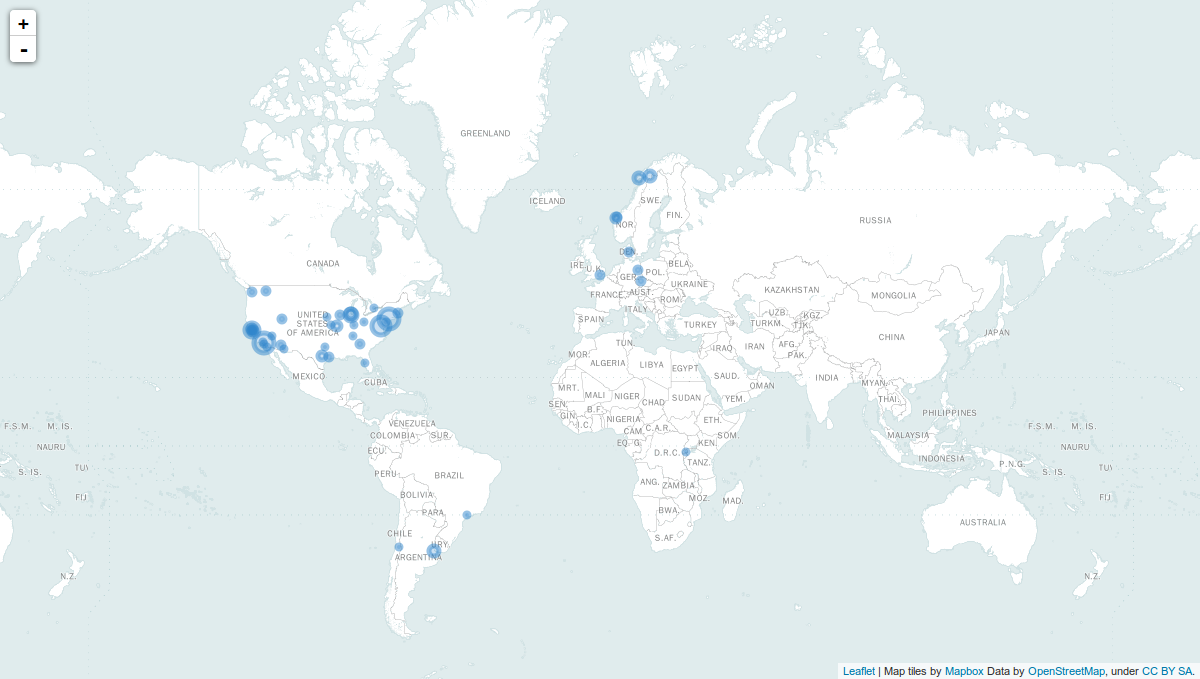

In [307]:
Image(os.path.join(output_dir, "contributor_map.png"))

In [308]:
contributions_map = folium.Map(location=[35, -102], zoom_start=2, tiles="Mapbox Bright")
for i, row in location_map_data.iterrows():
    radius = calculate_radius('contributions', row['contributions'])
    folium.CircleMarker([row.location_y, row.location_x],
        radius=radius,
        popup=row.location.decode("utf-8"),
        color='#3186cc',
        fill_color='#3186cc',
        fill_opacity=0.25,
    ).add_to(contributions_map)

In [309]:
contributions_map.save(os.path.join(output_dir, "contributions_map.html"))

In [310]:
screenshot_map("contributions_map")

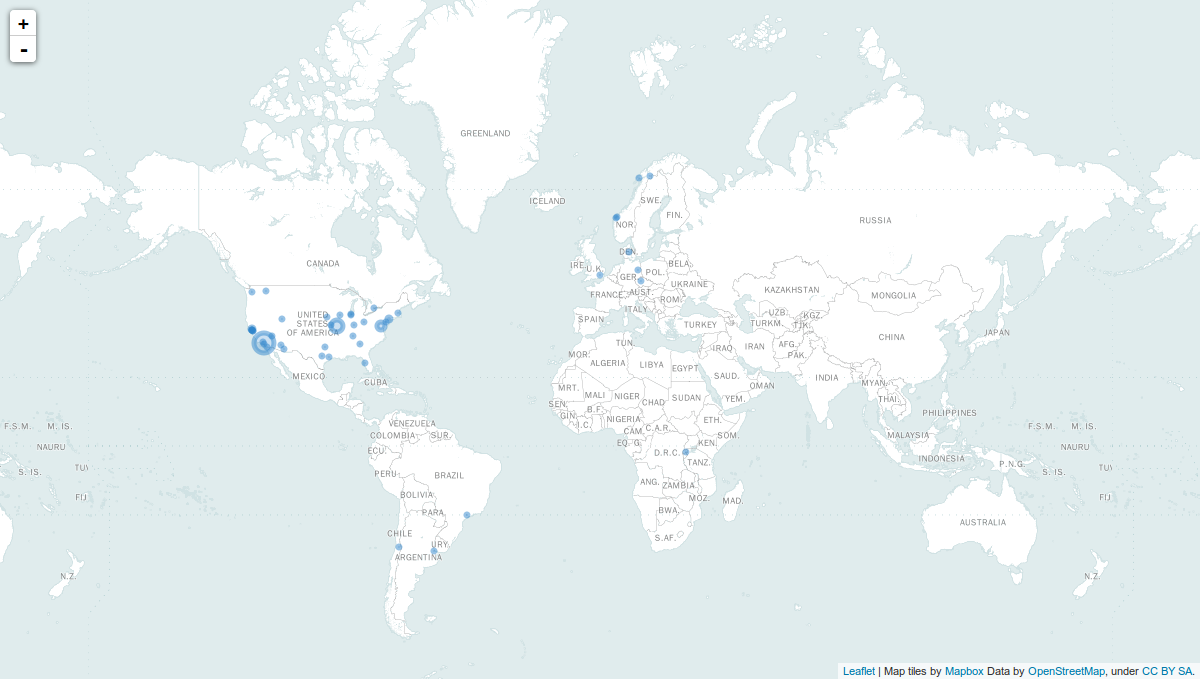

In [311]:
Image(os.path.join(output_dir, "contributions_map.png"))

In [232]:
create_ranking(unique_contributors, 'in_coalition').head(20)

,in_coalition,count,contributions,count_percent,contributions_percent
1,True,7,4847,0.05,0.89
0,False,137,569,0.95,0.11


In [233]:
create_ranking(unique_contributors, 'in_california').head(20)

,in_california,count,contributions,count_percent,contributions_percent
1,True,41,3271,0.28,0.60
0,False,103,2145,0.72,0.40


In [234]:
create_ranking(unique_contributors, 'in_usa').head(20)

,in_usa,count,contributions,count_percent,contributions_percent
1,True,114,5325,0.79,0.98
0,False,15,52,0.10,0.01


In [235]:
create_ranking(unique_contributors, 'state').head(20)

,state,count,contributions,count_percent,contributions_percent
1,CA,41,3271,0.28,0.60
9,MO,4,1332,0.03,0.25
2,DC,15,428,0.10,0.08
12,NY,19,167,0.13,0.03
6,IL,9,38,0.06,0.01
16,TX,7,19,0.05,0.00
10,NE,1,12,0.01,0.00
19,WA,2,9,0.01,0.00
3,FL,1,9,0.01,0.00
13,OH,1,7,0.01,0.00


In [236]:
create_ranking(unique_contributors, 'country').head(20)

,country,count,contributions,count_percent,contributions_percent
9,United States of America,114,5325,0.79,0.98
0,Argentina,5,30,0.03,0.01
8,Rwanda,1,11,0.01,0.00
4,Czech Republic,1,9,0.01,0.00
7,Norway,4,4,0.03,0.00
1,Brazil,1,2,0.01,0.00
2,Canada,1,2,0.01,0.00
3,Chile,1,1,0.01,0.00
5,Denmark,1,1,0.01,0.00
6,Germany,1,1,0.01,0.00
